# Deep Generative Models: Diffusion Models for Molecule Generation





## 0. Setup

1. To use a GPU, select `Runtime/Change runtime type` instead, and select `T4 GPU` as your `Runtime accelerator`.


2. please git clone the repository and install the dependencies for this course running the following


In [1]:
# Cloning the repo
#!git clone https://github.com/vgsatorras/probai24.git

In [2]:
# Installing dependencies
# !pip install torch-geometric

## 1. Code a Diffusion Model for a toy dataset


### 1.1 Code up the diffusion process $q(z_t | z_0)$


In `probai24.src.models.ddpm.DDPM` implement `get_coefs` to obtain the coefficients of different noise schedules. (You can navigate over the code files by pressing image.png  on the left menu).

1. We are going to use a Linear noise schedule:

  * Set the betas to be linearly spaced between beta_min=0.0001 and beta_max=0.02
  * Set $\alpha_t = 1-\beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$

  After you are done, run the following test to see if your implemetation is correct.


In [3]:
!python -m pytest -k "linear" probai24/tests/test_coefficients.py

============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-7.4.4, pluggy-1.5.0
rootdir: /Users/martineh/Documents/Code/NordicProbAI-SummerSchool2024/nordic-probai-2024/day3
plugins: anyio-4.4.0
collected 8 items / 4 deselected / 4 selected                                  

probai24/tests/test_coefficients.py ....                                 [100%]

======================= 4 passed, 4 deselected in 0.70s ========================




3. Implement the mean and std (standard deviation) of the marginal distribution $q(z_t | z_0) = \mathcal{N}\left(z_t ; \sqrt{\bar{\alpha}_t} z_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)$ in the methods `_q_mean` and `_q_std`. We've provided a handy function called `broadcast_like`; you can use it to match the shapes.

  Run the following when you're done.



In [4]:
!python -m pytest probai24/tests/test_q.py

============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-7.4.4, pluggy-1.5.0
rootdir: /Users/martineh/Documents/Code/NordicProbAI-SummerSchool2024/nordic-probai-2024/day3
plugins: anyio-4.4.0
collected 2 items                                                              

probai24/tests/test_q.py ..                                              [100%]

============================== 2 passed in 0.74s ===============================


4. Implement the *Mean-Squared-Error* loss for the noise-predicting model in `_losses` $$\|\epsilon - \epsilon_\text{pred}\|^2$$

  Verify your result!

In [5]:
!python -m pytest probai24/tests/test_loss.py

============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-7.4.4, pluggy-1.5.0
rootdir: /Users/martineh/Documents/Code/NordicProbAI-SummerSchool2024/nordic-probai-2024/day3
plugins: anyio-4.4.0
collected 1 item                                                               

probai24/tests/test_loss.py .                                            [100%]

============================== 1 passed in 0.78s ===============================


5. Last but not least! Implement the sampling components of the diffusion model.
* Read through the the `sample` method to understand how sample is iteratively refined through the Markovian transitional kernal $p(z_{t-1} | z_t)$.
* Implement the mean (`_p_mean`) and std (`_p_std`) of $$p(z_{t-1} | z_t)=\mathcal{N}\left(z_{t-1}; \frac{1}{\sqrt{\alpha_t}}\left(z_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta\left(z_t, t\right)\right) , \beta_t\right)$$
Note that the noise-predicting model `self.model` expects input arguments of the order `z`, `t/self.N`, `edge_idx`, `batch` and `context`. The last three are for passing information about molecules and for conditioning. Remember to pass all of them!

  Check if your implementation is correct.

In [6]:
!python -m pytest probai24/tests/test_p.py

============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-7.4.4, pluggy-1.5.0
rootdir: /Users/martineh/Documents/Code/NordicProbAI-SummerSchool2024/nordic-probai-2024/day3
plugins: anyio-4.4.0
collected 2 items                                                              

probai24/tests/test_p.py ..                                              [100%]

============================== 2 passed in 0.80s ===============================



### 1.2 In this session, we will train the DDPM you just implemented on a toy 2D distribution that can be easily visualized.

Now since you just implemented the core methods of the DDPM class, you may need to restart the kernel of this notebook. If that is the case, then select `Runtime/Restart session` from the dropdown menu. After the kernel is restarted, you should still be able to use the dependencies you installed earlier and load the DDPM you just implemented.

Skip all of the tests above, and continue from here.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import torch
from torch.utils.data import DataLoader

from probai24.src.data.data import DataBatch
from probai24.src.models.ddpm import DDPM
from probai24.src.training.training_loop import Trainer

Plot some samples for the Two Moons dataset



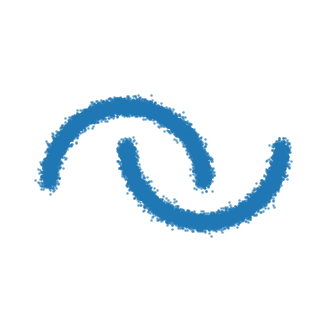

In [8]:
def plot_samples(samples):
    plt.figure(figsize=(4, 4))
    plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    # remove the frame and ticks
    plt.box(False)
    plt.xticks([])
    plt.yticks([])


def get_toy_dataset(n):
    samples = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
    samples -= np.array([[0.5, 0.25]])
    return samples


# plot the samples
plot_samples(get_toy_dataset(20000))

Create dataloaders and initialize neural networks



In [9]:
# create a data loader for the samples
batch_size = 256

def collate_to_batch(samples):
    x = torch.from_numpy(np.stack(samples, axis=0))
    batch = torch.LongTensor(range(x.shape[0]))
    return DataBatch(x=x, batch=batch)


train_loader = DataLoader(
    get_toy_dataset(50000),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_to_batch,
    drop_last=True
)
val_loader = DataLoader(
    get_toy_dataset(2000),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_to_batch
)

# Define the neural network that defines the Score Function
class ResidualBlock(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim, dim),
            torch.nn.ELU(),
            torch.nn.Linear(dim, dim)
        )
    def forward(self, x):
        return torch.nn.functional.elu(x + self.net(x))

class ScoreModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        dimh = 256
        self.epsilon_predictor = torch.nn.Sequential(
            torch.nn.Linear(3, dimh),
            torch.nn.ELU(),
            ResidualBlock(dimh),
            ResidualBlock(dimh),
            torch.nn.Linear(dimh, 2)
        )

    def forward(self, z_t, t, **kwargs):
        # concatenate the input with the continuous time
        z_t = torch.cat([z_t, t.unsqueeze(1) * 2 - 1], dim=1)

        # predict the score
        score = self.epsilon_predictor(z_t)
        return score


Instantiate the model

In [10]:
N = 1000
ddpm = DDPM(noise_schedule_type="linear", model=ScoreModel(), N=N)


Visualize the perturbed data

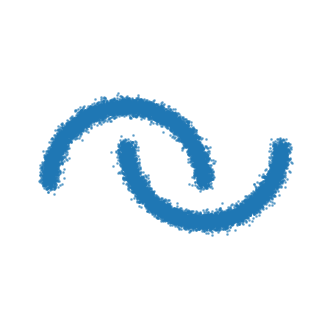

In [11]:
t = 1   # increase this value from 1 to 999 to see the effect of diffusing
plot_samples(ddpm.q_sample(torch.from_numpy(get_toy_dataset(20000)), torch.ones(20000).long() * t)[0])

Instantiate a trainer and train for 100 epochs

In [12]:
trainer = Trainer(ddpm, lr=0.001)
trainer.train(train_loader, val_loader, epochs=100, device=torch.device('cpu'))  # set to cpu if you didn't select GPU as your device

100%|██████████| 100/100 [01:35<00:00,  1.05it/s] [01:35<00:00,  1.08it/s, Epoch=99, Val_loss=0.388]


You can visualize the validation loss

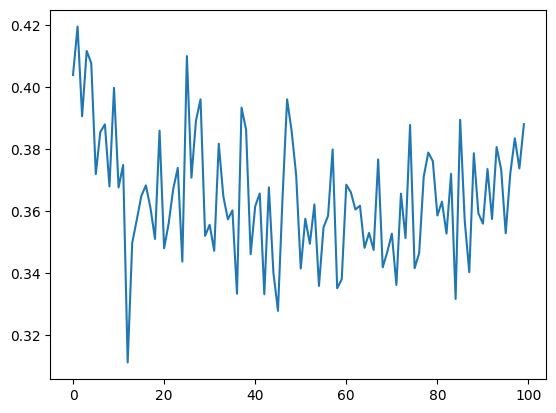

In [13]:
# Plot val loss
plt.plot(trainer.val_losses)

Visualize the samples drawn from the model

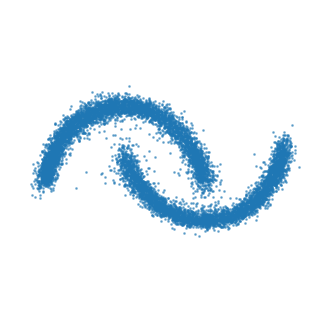

In [14]:
# Plot generated samples
samples = ddpm.sample([10000, 2])
plot_samples(samples)

## 2. Mini QM9 Dataset Analysis

In [15]:

from probai24.src.data.mini_qm9 import MiniQM9Dataset
from torch_geometric.loader import DataLoader
from probai24.src.evaluation.visualizer import plot_data3d
from probai24.src.evaluation.stability_analyze import check_stability
import torch
from tqdm.notebook import tqdm


For this session we will use the MiniQM9Dataset, which is a subset of the [QM9 dataset](https://www.nature.com/articles/sdata201422) with molecules consisting of at most 15 atoms.

In [16]:
dataset_train = MiniQM9Dataset(file_path="probai24/raw_data/mini_qm9_train.pickle")
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)

dataset_valid = MiniQM9Dataset(file_path="probai24/raw_data/mini_qm9_valid.pickle")
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
print(f"Number of training samples: \t{len(dataset_train)} \nNumber of validations samples: \t{len(dataset_valid)}")


Number of training samples: 	19058 
Number of validations samples: 	3408


Some basic information of a single molecule from MiniQM9:

In [17]:
# Analyze the structure of a single by loading a sample from the dataloader with batch_size = 1.
for batch in dataloader_train:
    # x: The positions of the atoms in the molecule (coordinates)
    print(f"x (3D coordinates): \t \t \t {batch.x.shape}")

    # h: The one-hot representation of the atom types
    print(f"h (one-hot atom types): \t\t {batch.h.shape}")

    # edge_index: The adjacency matrix of the molecular graph
    print(f"edge_index (adjacency matrix): \t\t {batch.edge_index.shape}")

    # context: The context index of each graph
    print(f"context (mol property: polarizability):\t {batch.context.shape}")

    # batch: A tensor assigning each node to its respective graph in the batch
    print(f"batch (node-to-graph assignment): \t {batch.batch.shape}")

    break

x (3D coordinates): 	 	 	 torch.Size([15, 3])
h (one-hot atom types): 		 torch.Size([15, 5])
edge_index (adjacency matrix): 		 torch.Size([2, 210])
context (mol property: polarizability):	 torch.Size([1])
batch (node-to-graph assignment): 	 torch.Size([15])


Lets visualize some molecules!

Data(x=[15, 3], edge_index=[2, 210], h=[15, 5], context=[1])


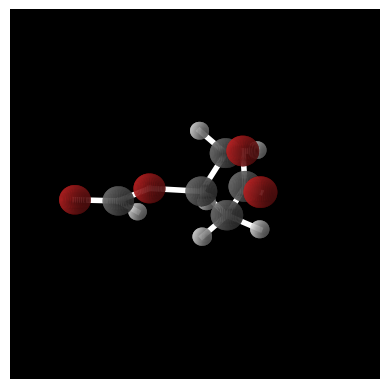

Data(x=[11, 3], edge_index=[2, 110], h=[11, 5], context=[1])


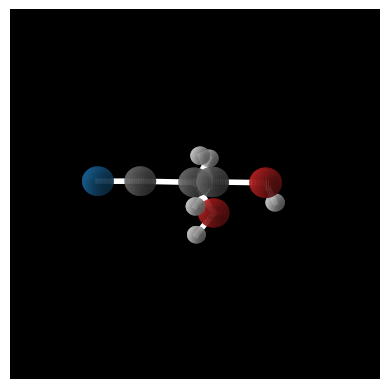

Data(x=[15, 3], edge_index=[2, 210], h=[15, 5], context=[1])


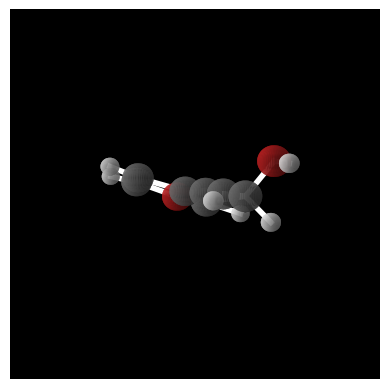

Data(x=[15, 3], edge_index=[2, 210], h=[15, 5], context=[1])


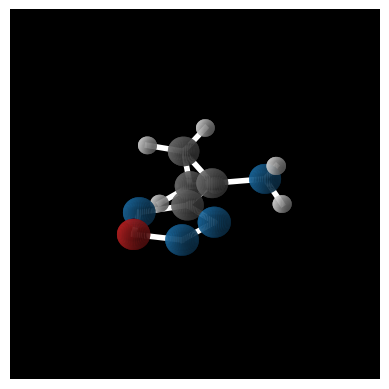

Data(x=[14, 3], edge_index=[2, 182], h=[14, 5], context=[1])


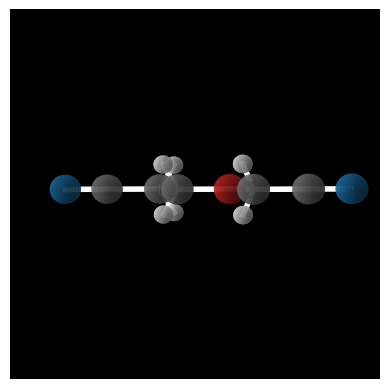

In [18]:
# Load and visualize a few samples from the MiniQM9Dataset
num_plotted_samples = 4
for idx, batch in enumerate(dataset_train):
    # Print the current batch information
    print(batch)

    # Convert the one-hot encoded atom types to integer labels
    h_atom_type = torch.argmax(batch.h, dim=1).numpy()

    # Visualize the molecular structure using plot_data3d
    # batch.x contains the 3D coordinates of the atoms
    # h_atom_type contains the atom type labels
    # spheres_3d=True enables the 3D sphere representation for atoms. Se to False for faster speed.
    plot_data3d(batch.x, h_atom_type, spheres_3d=True)

    if idx >= num_plotted_samples:
        break


### Valency test

**Atom stability**: We say an atom is *stable* when the sum of its bond orders is equal to a known heuristic called valency. For example, Hydrogen atoms have have a valence number of 1. Therefore, they will be considered stable when having a single bond with another atom. The valency of a carbon atom is 4, so they could have up to 4 single bonds (e.g. with hydrogen atoms, forming a Methane molecule) or 2 double bonds (e.g. with oxygen atoms creating, forming a carbon dioxide molecule).


**Molecule stability**: We say a molecule is *stable* when all of its atoms are stable.


Next we compute the stability metrics for MiniQM9. Since we are using some heuristics to compute the bond orders (just looking at pairwise distances), not all molecules are stable. But this will still be a useful useful that can give us some insight on our trained model.

In [19]:

# Initialize a dictionary to store the counts of stable molecules and atoms, as well as the total number of molecules and atoms
st_dict = {"num_stable_mols": 0, "num_mols":0, "num_stable_atoms": 0, "num_atoms": 0}
for idx, batch in enumerate(tqdm(dataloader_valid, desc="Evaluating stability")):

    # Convert the one-hot encoded atom types to integer labels
    h_atom_type = torch.argmax(batch.h, dim=1).numpy()

    # Check the stability of the current molecule and count the number of stable atoms.
    mol_stable, num_stable_atoms, num_atoms = check_stability(batch.x, h_atom_type)

    # Update the stability dictionary with the results
    st_dict["num_stable_mols"] += mol_stable
    st_dict["num_mols"] += 1
    st_dict["num_stable_atoms"] += num_stable_atoms
    st_dict["num_atoms"] += num_atoms


# Calculate the atom and molecule stability ratios and print the results.
atom_st = st_dict['num_stable_atoms']/st_dict['num_atoms']
mol_st = st_dict['num_stable_mols']/st_dict['num_mols']
print(f"Atom stability: {atom_st} \t Molecule Stability {mol_st}")



Evaluating stability:   0%|          | 0/3408 [00:00<?, ?it/s]

Atom stability: 0.976038881107008 	 Molecule Stability 0.8656103286384976


## 3. Train a DDPM on MiniQM9

Recall that we want to generate both atom types (h) and atom coordinates
(x) at once. Atom types are discrete variables, and we represented them using one-hot encodings. To jointly diffuse the both of them, we would simply concatenate x and h in the code.

**TO DO:** Now in `src.ddpm.DDPM.losses`, implement this simple logic for the case "h is not None".

You may need to restart the Kernel again in `Runtime` -> `Restart Session`

In [20]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.loader import DataLoader
import yaml

from probai24.src.data.mini_qm9 import MiniQM9Dataset
from probai24.src.evaluation.evaluator import Evaluator
from probai24.src.models.ddpm import DDPM
from probai24.src.models.egnn import EGNNScore
from probai24.src.training.training_loop import Trainer

In [21]:
# Load train and val dataloaders
train_dataset = MiniQM9Dataset(file_path="probai24/raw_data/mini_qm9_train.pickle")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = MiniQM9Dataset(file_path="probai24/raw_data/mini_qm9_valid.pickle")
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

Ininitialize EGNN as the noise prediction model, and initialize DDPM.


You can play with the setting of DDPM (e.g. change the number of diffusion steps `N` or type `linear` or `cosine`) and see if the performance would be different.

In [22]:
# Initialize EGNN
with open("probai24/configs/default_config.yml", 'r') as file:
    config = yaml.safe_load(file)

egnn_config = config['EGNN']
hidden_nf = egnn_config['hidden_nf']
n_layers = egnn_config['n_layers']
score = EGNNScore(
    in_node_nf=5 + 1, # 5 for the one hot encoding, 1 for diffusion time
    hidden_nf=hidden_nf,
    n_layers=n_layers,
    out_node_nf=5
) # 5 atom types in QM9

# Initialize DDPM
ddpm_config = config['DDPM']
N = config['DDPM']['N'] # Numbero of noise level, default set to 100
ddpm = DDPM(noise_schedule_type="linear", model=score, N=N)
trainer = Trainer(ddpm, lr=0.0005, checkpoints_path="probai24/checkpoints/egnn_checkpoint.pth")


Epochs Progress: 100%|██████████████████| 100/100 [02:05<00:00,  1.25s/it, Epoch=99, Val_loss=0.388]


Start training!

100%|██████████| 50/50 [23:30<00:00, 28.20s/it]50 [23:30<00:00, 28.52s/it, Epoch=49, Val_loss=0.972]


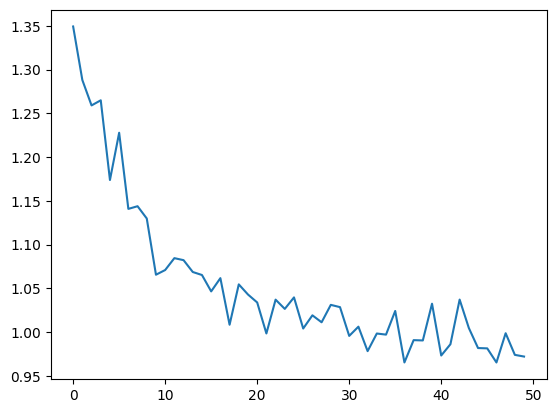

In [23]:
trainer.train(train_loader, valid_loader, epochs=50, device=torch.device('cpu'))
plt.plot(trainer.val_losses)


If you want to load a checkpoint of a pre-trained model, simply run
```*python*
trainer.load_checkpoint("probai24/checkpoints/egnn_checkpoint.pth")
```

You can also load the checkpoint of a model pre-trained by us if it takes too long to train at `probai24/checkpoints/egnn_checkpoint_instructors.pth`.

In [24]:
# trainer.load_checkpoint("probai24/checkpoints/egnn_checkpoint_instructors.pth")

In [26]:
# Generate some samples (same as loader_valid.batch_size)
evaluator = Evaluator(ddpm, valid_loader=valid_loader)
x, h, ptr = evaluator.sample_batch(device=torch.device("cpu"))

Generating a batch of 128 samples.


Remember we concatenate the one-hot encodings of the atom types and diffuse them along with the atom coordinates. Now the generated h should be *close to* a one-hot encoding. Before further evaluation and plotting, we now project it back to a discrete value by applying the argmax operator.

In [27]:
h = torch.argmax(h, dim=1)

Evaluate the stability of the atoms / molecules

In [28]:
# For a model trained in few epochs we should already expect good atomic stability
# Stability on a molecular level might be hard to improve. It typically takes longer to train and fine-tune the model.
# Don't worry if you get ~0.0% :D

atom_st, mols_st = evaluator.eval_stability(x, h, ptr)
print(f"Atom stability: {atom_st} \t Molecule stability: {mols_st}")

Evaluating stability on 128 samples
Atom stability: 0.6666666666666666 	 Molecule stability: 0.0


Let's visualize some molecules generated by our model!

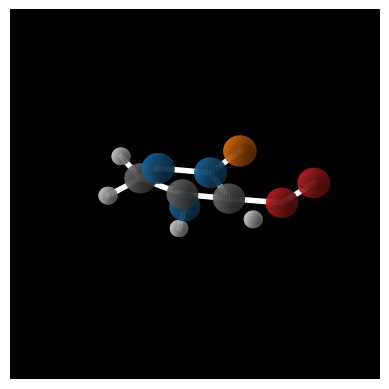

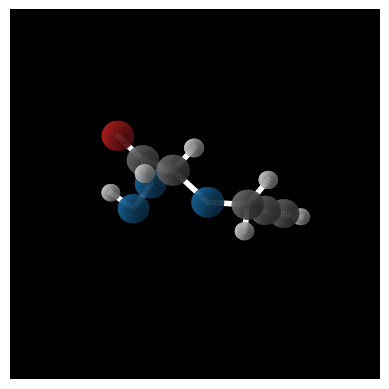

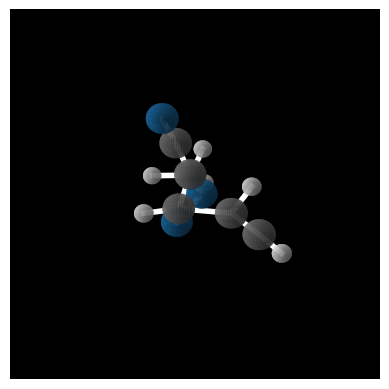

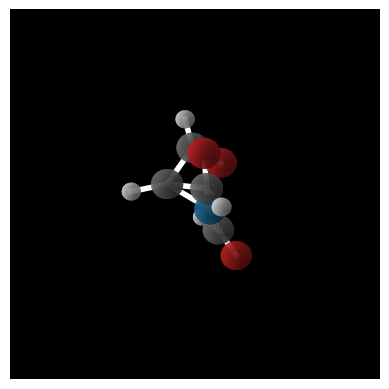

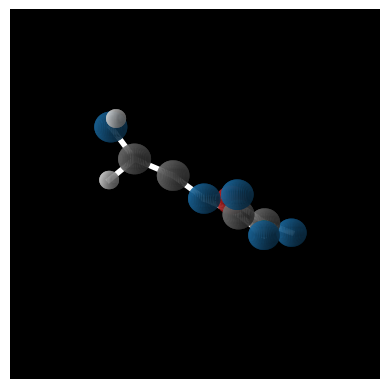

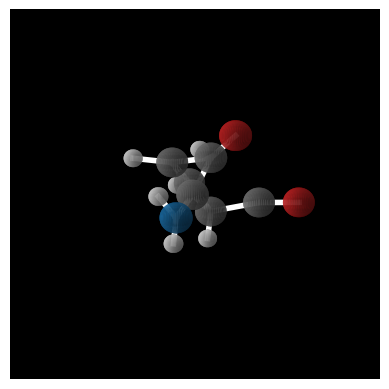

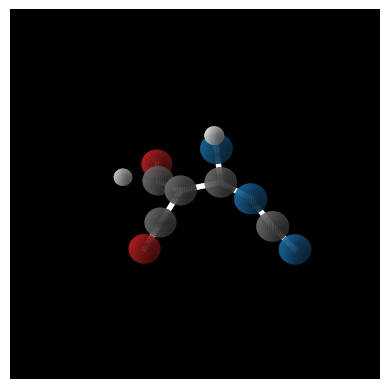

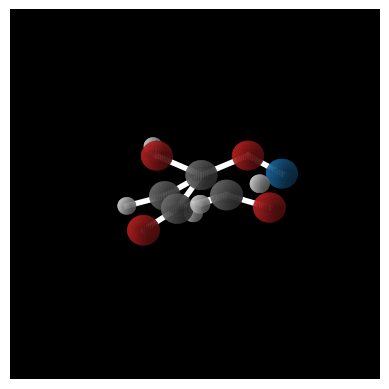

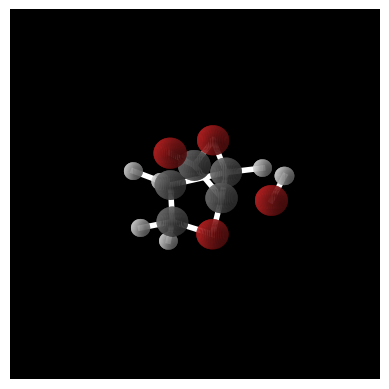

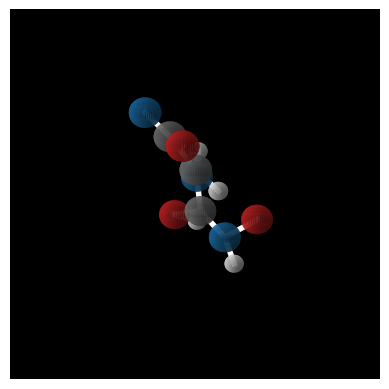

In [29]:
evaluator.eval_plot(x, h, ptr, max_num_plots=10)